# Practical Work: Reinforcement Learning
## Part 2: Solving the CarRacing environment

On this environment, like a real human, we need to learn from pixels.  
The observable space is really big, thus we need to reduce it by hand-crafting features, or by Deep Learning.
- Hand-crafting features heavilly use image processing (find contour, lines, predict motion...).
- Deep Learning on images heavilly use Convolutionnal Neural Networks to extract features from pixels.

Then, we need to choose our next action (state space is also big) by Control Theory or by using a Deep predictive model. Note that the action space is low here.  

Here, we will take the Deep Learning way.

# II - CarRacing

Easiest continuous control task to learn from pixels, a top-down racing environment.  

Discret control is reasonable in this environment as well, on/off discretisation is fine.  
State consists of __STATE_W x STATE_H pixels__.  

## Reward
Reward is __-0.1 every frame__ and __+1000/N for every track tile visited__, where N is the total number of tiles in track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.  

## Solving
CarRacing-v0 defines "solving" as getting __average reward of 900 over 100 consecutive trials__.

## Track
Track is __random every episode__.  
Episode finishes when all tiles are visited. Car also can __go outside of PLAYFIELD__, that is far off the track, then it will get __-100 and die__.  

## Indicators
Some indicators shown at the bottom of the window and the state RGB buffer:  

- true speed  
- 4 ABS sensors  
- steering wheel position  
- gyroscope  

Environment created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

## Technical fixes
### HDPI fix 1
[OpenAI's GitHub issue](https://github.com/openai/gym/issues/492#issuecomment-278181766)  
Additionally, to fix large window you can change display DPI on your Mac, or change:  

```python
WINDOW_W = 1200
WINDOW_H = 1000
```
in `gym/envs/box2d/car_racing.py` to smaller values.

### HDPI fix 2
[OpenAI's GitHub issue](https://github.com/openai/gym/issues/1268#issuecomment-450603215)  
Change line 386 of car_racing.py to:  
`gl.glViewport(0, 0, WINDOW_W*2, WINDOW_H*2)`

```bash
avconv -version
if not brew install libav
```

## 1 - Play by yourself!

In [7]:
# Try to play by yourself!
import gym
from pyglet.window import key
import numpy as np
import time

bool_do_not_quit = True  # Boolean to quit pyglet
scores = []  # Your gaming score
a = np.array( [0.0, 0.0, 0.0] )  # Actions

def key_press(k, mod):
    global bool_do_not_quit, a, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_do_not_quit=False  # To Quit
    if k==key.Q: bool_do_not_quit=False  # To Quit
    if k==key.LEFT:  a[0] = -1.0
    if k==key.RIGHT: a[0] = +1.0
    if k==key.UP:    a[1] = +1.0
    if k==key.DOWN:  a[2] = +0.8   # set 1.0 for wheels to block to zero rotation

def key_release(k, mod):
    global a
    if k==key.LEFT  and a[0]==-1.0: a[0] = 0
    if k==key.RIGHT and a[0]==+1.0: a[0] = 0
    if k==key.UP:    a[1] = 0
    if k==key.DOWN:  a[2] = 0

def run_carRacing_asHuman(policy=None, record_video=False):
    global bool_do_not_quit, a, restart
    # env = CarRacing()
    env = gym.make('CarRacing-v0').env

    env.reset()
    env.render()
    if record_video:
        env.monitor.start('/tmp/video-test', force=True)
    env.viewer.window.on_key_press = key_press
    env.viewer.window.on_key_release = key_release

    while bool_do_not_quit:
        env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        t1 = time.time()  # Trial timer
        while bool_do_not_quit:
            state, reward, done, info = env.step(a)
            # time.sleep(1/10)  # Slow down to 10fps for us poor little human!
            total_reward += reward
            if steps % 200 == 0 or done:
                print("Step: {} | Reward: {:+0.2f}".format(steps, total_reward), "| Action:", a)
            steps += 1
            if not record_video: # Faster, but you can as well call env.render() every time to play full window.
                env.render()
            if done or restart:
                t1 = time.time()-t1
                scores.append(total_reward)
                scores.append(total_reward)
                print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                break
        if not bool_do_not_quit:
            scores.append(total_reward)
            print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
    env.close()

run_carRacing_asHuman()  # Run with human keyboard input

Track generation: 1140..1436 -> 296-tiles track
Track generation: 1107..1388 -> 281-tiles track
Step: 0 | Reward: +7.04 | Action: [0. 0. 0.]
Step: 200 | Reward: +22.76 | Action: [0. 1. 0.]
Step: 400 | Reward: +59.90 | Action: [0.  0.  0.8]
Step: 600 | Reward: +39.90 | Action: [1. 1. 0.]
Trial 2 | Score: 22.999999999999254 | 770 steps | 20.88s.
Track generation: 1025..1288 -> 263-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1068..1339 -> 271-tiles track
Step: 0 | Reward: +7.31 | Action: [0. 0. 0.]
Step: 200 | Reward: +31.75 | Action: [-1.  1.  0.]
Step: 400 | Reward: +48.79 | Action: [0.  0.  0.8]
Step: 600 | Reward: +158.42 | Action: [0. 0. 0.]
Step: 800 | Reward: +264.34 | Action: [0.  0.  0.8]
Trial 3 | Score: 261.1444444444442 | 833 steps | 1551202624.86s.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My human performance on CarRacing-v0')
plt.ylabel('Score')
plt.xlabel('Human Episode')
plt.show()

## 2 - Create an Agent to solve the problem

- Reinforcement Learning
    - Policy Gradient
    - Imitation Learning
    - Deep Q-Learning

In [2]:
import gym
import numpy as np
# Define the Environments
env = gym.make('CarRacing-v0').env

# Number of Dimensions in the Observable Space and number of Control Actions in the Environments
print('Observation Space:', env.observation_space)
print('Action Space:', env.action_space)

print("\n")
print("Observation Space Param: 96x96x3 values for Red, Green and Blue pixels")
print("Observation Space Highs:", np.mean(env.observation_space.high))
print("Observation Space Lows:   ", np.mean(env.observation_space.low))

Observation Space: Box(96, 96, 3)
Action Space: Box(3,)


Observation Space Param: 96x96x3 values for Red, Green and Blue pixels
Observation Space Highs: 255.0
Observation Space Lows:    0.0


In [12]:
# Run the environment

from collections import deque
import gym
import numpy as np
from pyglet.window import key
import time

bool_quit = False

def key_press(k, mod):
    global bool_do_not_quit, action, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_do_not_quit=False  # To Quit
    if k==key.Q: bool_do_not_quit=False  # To Quit
    if k==key.LEFT:  action[0] = -1.0
    if k==key.RIGHT: action[0] = +1.0
    if k==key.UP:    action[1] = +1.0
    if k==key.DOWN:  action[2] = +0.8   # set 1.0 for wheels to block to zero rotation

def key_release(k, mod):
    global action
    if k==key.LEFT  and action[0]==-1.0: action[0] = 0
    if k==key.RIGHT and action[0]==+1.0: action[0] = 0
    if k==key.UP:    action[1] = 0
    if k==key.DOWN:  action[2] = 0

def run_carRacing(policy, n_episodes=1000, max_t=1500, print_every=100, record_video=False):
    """Run the CarRacing-v0 environment.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): how often to print average score (over last 100 episodes)

    Adapted from:
    https://gist.github.com/lmclupr/b35c89b2f8f81b443166e88b787b03ab

    """
    global bool_quit

    if policy.__class__.__name__ == 'Policy_Human':
        global action
        action = np.array( [0.0, 0.0, 0.0] ) # Global variable used for manual control actions with key_press
        env = gym.make('CarRacing-v0').env
        env.reset()  # This is mandatory for keyboard input
        env.render()  # This is mandatory for keyboard input
        env.viewer.window.on_key_press = key_press
        env.viewer.window.on_key_release = key_release
    else:
        print('** Evaluating', policy.__class__.__name__, '**')
        # Define the Environments
        env = gym.make('CarRacing-v0').env
        # Set random generator for reproductible runs
        env.seed(0)
        np.random.seed(0)

    if record_video:
        env.monitor.start('/tmp/video-test', force=True)

    scores_deque = deque(maxlen=100)
    scores = []
    trials_to_solve=[]

    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        if 'reset' in dir(policy):  # Check if the .reset method exists
            policy.reset(state)
        for t in range(max_t):  # Avoid stucked episodes
            action = policy.act(state)
            state, reward, done, info = env.step(action)
            rewards.append(reward)
            if 'memorize' in dir(policy):  # Check if the .memorize method exists
                policy.memorize(state, action, reward, done)
            # Environment must be rendered! If not, all pixels are white...
            env.render()  # (mode='rgb_array')
            if done:
                trials_to_solve.append(t)
                break
        # if t + 1 == max_t:
        #     print('This episode is stuck.')

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        if 'update' in dir(policy):  # Check if the .update method exists
            policy.update(state)  # Update the policy

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}\tSteps: {:d}'.format(i_episode, np.mean(scores_deque), t))
        if np.mean(scores_deque) >= 900.0:
            print('Episode {}\tAverage Score: {:.2f}\tSteps: {:d}'.format(i_episode, np.mean(scores_deque), t))
            print('** Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(1, i_episode-100), np.mean(scores_deque)))
            break
        if bool_quit:
            break

    if np.mean(scores_deque) < 900.0:
        print('** The environment has never been solved!')
        print('   Mean scores on last 100 runs was < 900.0')
    if record_video:
        env.env.close()
    env.close()
    return scores, trials_to_solve

In [4]:
#  Performance plots
import matplotlib.pyplot as plt
%matplotlib inline
def plot_performance(scores):
    # Plot the policy performance
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1, len(scores) + 1)
    y = scores
    plt.scatter(x, y, marker='x', c=y)
    fit = np.polyfit(x, y, deg=4)
    p = np.poly1d(fit) 
    plt.plot(x,p(x),"r--") 
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(policy.__class__.__name__ +  ' performance on CartPole-v0')
    plt.show()

def plot_trials_to_solve(trials_to_solve):
    # Plot the policy number of trials to solve the Environment
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(trials_to_solve, bins='auto', density=True, facecolor='g', alpha=0.75)
    plt.ylabel('Frequency')
    plt.xlabel('Number of Trial to solve')
    plt.title(policy.__class__.__name__ +  ' trials to solve CartPole-v0')
    plt.show()

### Temporal Difference (TD0)

#### Image processing for information reduction
From a _(96, 96, 3) = 27 648 values_ observation space to _(10*10 + 7 + 4) = 111 values_.  

Note that without this reduction, the problem is still solvable but with a significative computing power.  

#### From the original (96, 96, 3) pixels  image
- Crop the track to 10*10 pixels.
- Extract 1 steering setting, 1 speed, 1 gyro and 4 abs values from the bar on the window bottom

#### Resources
- #### [Original code from Luc Prieur](https://gist.github.com/lmclupr/b35c89b2f8f81b443166e88b787b03ab)  
- [Denny Britz excellent repository](https://github.com/dennybritz/reinforcement-learning)

In [5]:
# env = wrappers.Monitor(env, "monitor-folder", force=True)  # video_callable=lambda episode_id: True

In [6]:
import cv2
# Hand-crafted image processing to extract: 10*10 pixels track, upper and car images
def transform(state):
    # crop_img = img[200:400, 100:300]  # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    # bottom_black_bar is the section of the screen with steering, speed, abs and gyro information.
    # we crop off the digits on the right as they are illigible, even for ml.
    # since color is irrelavent, we grayscale it.
    bottom_black_bar = state[84:, 12:]
    img = cv2.cvtColor(bottom_black_bar, cv2.COLOR_RGB2GRAY)
    bottom_black_bar_bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
    bottom_black_bar_bw = cv2.resize(bottom_black_bar_bw, (84, 12), interpolation = cv2.INTER_NEAREST)

    # upper_field = observation[:84, :96]  # This is the section of the screen that contains the track
    upper_field = state[:84, 6:90]  # We crop side of screen as they carry little information
    img = cv2.cvtColor(upper_field, cv2.COLOR_RGB2GRAY)
    upper_field_bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)[1]
    upper_field_bw = cv2.resize(upper_field_bw, (10, 10), interpolation = cv2.INTER_NEAREST) # rescaled to 10*10 pixels
    upper_field_bw = upper_field_bw.astype('float') / 255

    car_field = state[66:78, 43:53]
    img = cv2.cvtColor(car_field, cv2.COLOR_RGB2GRAY)
    car_field_bw = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]
    car_field_t = [
        car_field_bw[:, 3].mean() / 255,
        car_field_bw[:, 4].mean() / 255,
        car_field_bw[:, 5].mean() / 255,
        car_field_bw[:, 6].mean() / 255]

    return bottom_black_bar_bw, upper_field_bw, car_field_t

In [7]:
def convert_argmax_qval_to_env_action(output_value):
    # we reduce the action space to 15 values.  9 for steering, 6 for gaz/brake.
    # to reduce the action space, gaz and brake cannot be applied at the same time.
    # as well, steering input and gaz/brake cannot be applied at the same time.
    # similarly to real life drive, you brake/accelerate in straight line, you coast while sterring.

    gaz = 0.0
    brake = 0.0
    steering = 0.0

    # output value ranges from 0 to 10
    
    if output_value <= 8:
        # steering. brake and gaz are zero.
        output_value -= 4
        steering = float(output_value) / 4
    elif output_value >= 9 and output_value <= 9:
        output_value -= 8
        gaz = float(output_value) / 3 # 33% 
    elif output_value >= 10 and output_value <= 10:
        output_value -= 9
        brake = float(output_value) / 2 # 50% brakes
    else:
        print("[WARNING] Error in convert_argmax_qval_to_env_action()")

    white = np.ones((round(brake * 100), 10))
    black = np.zeros((round(100 - brake * 100), 10))
    brake_display = np.concatenate((black, white))*255  
    
    white = np.ones((round(gaz * 100), 10))
    black = np.zeros((round(100 - gaz * 100), 10))
    gaz_display = np.concatenate((black, white))*255
        
    control_display = np.concatenate((brake_display, gaz_display), axis=1)

    # cv2.namedWindow('controls', cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('controls', 100, 20)
    # cv2.imshow('controls', control_display)
    # cv2.waitKey(1)

    return [steering, gaz, brake]

In [8]:
# This function uses the black bar at the window botttom to extract steering setting, speed and gyro data
def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean() / 255
    left_steering = a[6, 26:36].mean() / 255
    steering = (right_steering - left_steering + 1.0) / 2
    
    left_gyro = a[6, 46:60].mean() / 255
    right_gyro = a[6, 60:76].mean() / 255
    gyro = (right_gyro - left_gyro + 1.0) / 2
    
    speed = a[:, 0][:-2].mean() / 255
    abs1 = a[:, 6][:-2].mean() / 255
    abs2 = a[:, 8][:-2].mean() / 255
    abs3 = a[:, 10][:-2].mean() / 255
    abs4 = a[:, 12][:-2].mean() / 255
    
    # white = np.ones((round(speed * 100), 10))
    # black = np.zeros((round(100 - speed * 100), 10))
    # speed_display = np.concatenate((black, white))*255
        
    # cv2.imshow('sensors', speed_display)
    # cv2.waitKey(1)

    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

In [9]:
# Information reduction from the original image pixels:
#   - Crop the track to 10*10 pixels
#   - Extract 1 steering setting, 1 speed, 1 gyro and 4 abs values from the bar on the window bottom
state_space_dim = 10 * 10 + 7 + 4
print(state_space_dim)

111


Deep Neural Networks to model the Q Table:
** Found a local race-car.h5 model.
  race-car.h5 model loaded!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               57344     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
_________________________________________________________________
activation_2 (Activation)    (None, 11)                0         
Total params: 62,987
Trainable params: 62,987
Non-trainable params: 0
_________________________________________________________________
** Evaluating Policy_TD0 **
Track generation: 1143..1442 -> 299-tiles track
Episode 1	Average Score: -13.34	Steps: 979
Track generation: 1087..1369 -> 282-tiles tr

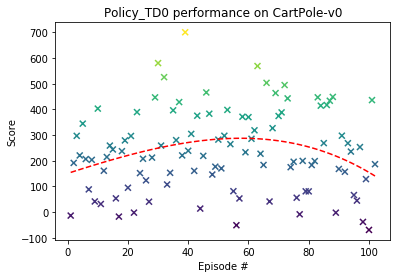

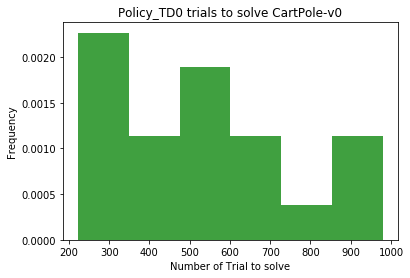

In [14]:
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam, Adamax
import math
import os
from pathlib import Path
import random
import shutil
import time

state_space_dim = 10 * 10 + 7 + 4  # We extract a 10*10 image and values from the window bottom
# 7*7 + 3.  or 14*14 + 3

# Define a Temporal Difference Policy
class Policy_TD0():
    def __init__(self, state_space_dim=state_space_dim, action_space_dim=3):
        self.action_space_dim = action_space_dim
        self.state_space_dim = state_space_dim
        self.gamma = 0.99  # 0.95 is slow  # Discount rate
        # self.epsilon = 1.0  # 1.0 0.2 1.0<->0.1  # This should be tuned carefuly
        self.epsilon = 0.5 / np.sqrt(901)
        # self.epsilon_min = 0.01  # 0.0001 0.001  
        self.epsilon_decay = 0.995  # 0.995
        self.learning_rate = 0.002  # 0.001  # This should be tuned carefuly
        self.learning_rate_decay = 0.01  # 0.01 Learning rate decay
        # self.batch_size = 64  # 32

        self.episode = 0  # Episode counter
        print('Deep Neural Networks to model the Q Table:')
        if os.path.exists('race-car.h5'):
            print('** Found a local race-car.h5 model.')
            self.model = load_model('race-car.h5')
            print('  race-car.h5 model loaded!')
        else:
            self.model = self._build_model(self.state_space_dim, action_space_dim)
        self.model.summary()
        # self.memory = [] 
        # self.memory = deque(maxlen=100000)  # We can limit the memory size

    def _build_model(self, state_space_dim, action_space_dim):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        print('** Build a 2FC layers to model the Q-table of this problem **')
        model.add(Activation('linear'))

        # Optimizer:
        # rms = RMSprop(lr=0.005)
        # sgd = SGD(lr=0.1, decay=0.0, momentum=0.0, nesterov=False)
        # Adam(lr=0.0005)
        # Adamax(lr=0.001)
        model.add(Dense(action_space_dim, activation='linear'))  # Linear output so we can have range of real-valued outputs
        model.compile(loss='mse', optimizer=Adamax(lr=self.learning_rate, decay=self.learning_rate_decay))

    def act(self, state):
        self.qval = self.model.predict(self.current_state, verbose=0)[0]

        # epsilon = max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((self.episode + 1) * self.epsilon_decay)))
        if np.random.random() < self.epsilon:  # epsilon-greedy action selection
            self.argmax_qval = random.randint(0, 10)
            # action = env.action_space.sample()
        else:
            self.argmax_qval = np.argmax(self.qval)
        return convert_argmax_qval_to_env_action(self.argmax_qval)

    def memorize(self, next_state, action, reward, done):
        # Memorize all observables and environment trial results
        a, b, c = transform(next_state)
        next_state = np.concatenate(  # this is 3 + 7*7 size vector.  all scaled in range 0..1
            (np.array([compute_steering_speed_gyro_abs(a)]).reshape(1,-1).flatten(),
             b.reshape(1,-1).flatten(), c), axis=0)
        next_state = np.array(next_state).reshape(1, self.state_space_dim)
        # self.memory.append((self.current_state, action, reward, next_state, done))

        # Standard Q-Learning TD(0)
        next_qval = self.model.predict(next_state, verbose=0)[0]
        G = reward + self.gamma * np.max(next_qval)
        y = self.qval[:]
        # y[np.argmax(self.qval)] = G
        y[self.argmax_qval] = G
        self.train(self.current_state, y)  # Update model on every run?
        self.current_state = next_state

    def update(self, state):
        self.episode += 1  # Increment trial counter
        # Train the Q-Network
        # if len(self.memory) > self.batch_size:  # If there are enough trial in memory
        # if len(self.memory) % 4:  # Train only every 4th trial
        # if len(self.memory) > 2000:  # We can lazy start to acquire more data before learn on it
        #     self.replay_to_train(self.batch_size)

        # Update epsilon
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay
        # self.epsilon = 0.5 / np.sqrt(self.episode + 1 + 900)
        self.epsilon = 0.5 / np.sqrt(self.episode + 900)

    def train(self, state, G):
        self.model.fit(state, np.array(G).reshape(1, 11), epochs=1, verbose=0)

    def replay_to_train(self, batch_size):  # TODO: implement TD
        state_batch, Q_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in minibatch:
            Q_target = self.model.predict(state)[0]  # Use the model to predict the target
            if done :  # Full reward because environment was solved
                Q_target[np.argmax(Q_target)] = reward
            else:  # Discount the reward by gamma because environment was not solved
                Q_target[np.argmax(Q_target)] = reward + self.gamma * np.max(self.model.predict(next_state)[0])

            state_batch.append(state[0])
            Q_batch.append(Q_target)
        self.model.fit(np.array(state_batch), np.array(Q_batch), batch_size=len(state_batch), verbose=0)

    def reset(self, state):
        # Set current_state
        a, b, c = transform(state)  # this is 3 + 7*7 size vector.  all scaled in range 0..1
        self.current_state = np.concatenate((np.array([compute_steering_speed_gyro_abs(a)]).reshape(1, -1).flatten(),
                b.reshape(1, -1).flatten(), c), axis=0).reshape(1, self.state_space_dim)

    def save_model(self):
        filepath = 'race-car.h5'
        if Path(filepath).exists():
            timestamp = os.stat(filepath).st_ctime
            print('** OLD', filepath, 'exists! Created:', time.ctime(timestamp))
            shutil.copy(filepath, filepath + '_' + str(timestamp))
        self.model.save('race-car.h5')
        print('** Model saved to', filepath, '!')

policy = Policy_TD0()
scores, trials_to_solve = run_carRacing(policy, n_episodes=102, max_t=1000, print_every=1)

** Mean average score: 239.06616008258862


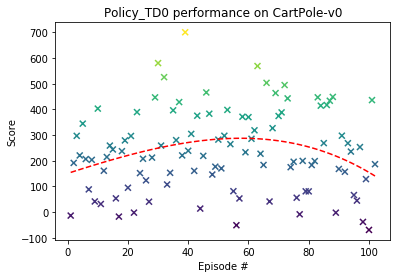

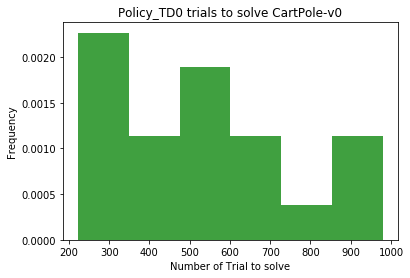

In [18]:
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

In [17]:
# Save the model
policy.save_model()

# Going further

## On self-driving car
[Comma.ai's real self-driving dataset & solutions](https://github.com/commaai/research)
[Self Racing Car challenge & dataset](http://selfracingcars.com/)

## On latent-space Reinforcement Learning: World Models  
- [Ha and Schmidhuber, "Recurrent World Models Facilitate Policy Evolution", 2018](https://worldmodels.github.io/)  
- [Hardmaru blog post on World Models](http://blog.otoro.net/2018/06/09/world-models-experiments/)  
- [PlaNet](https://planetrl.github.io/), and the paper: [Learning Latent Dynamics for Planning from Pixels, Hafner & al., 2018](https://arxiv.org/abs/1811.04551)

## David Silver course
[Reinforcement Learning course page](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html), [Videos on YouTube](https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ)

## Richard Sutton & Andrew Barto book
[Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html)

## OpenAI docs  
- [Spinning Up in Deep RL](https://spinningup.openai.com/)  
- [Requests for Research](https://openai.com/requests-for-research/) 

## Technical hints
- [How to Parallelize Environments?](https://www.reddit.com/r/MachineLearning/comments/8aimei/d_what_is_the_right_way_to_parallelize_rollouts/)
- [Hot to Create an Environment in Gym](https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai)